DepreSys4 data variables are saved in separate netcdf files for T, U, and V grids. Altough lat/lon values are different for these grids, same dimension and coordinate names are in netcdf files. Hence, it would be wrong to combine these data files using `xr.merge` as grid info will not correct. A user first needs to rename dimensions and update coordinate values before combinging the data files. 

A working example is shown below. We combine cell area variables and save them in a separate nc file. These variables are required for area-weighted means.

In [1]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [58]:
# Read Data Files

path = "/home/users/hkhatri/DePreSys4_Data/Test_Data/ONM_Monthly/"

ds_T = xr.open_dataset(path + "nemo_av830o_1m_19810301-19810401_grid-T.nc")

ds_U = xr.open_dataset(path + "nemo_av830o_1m_19810301-19810401_grid-U.nc")

ds_V = xr.open_dataset(path + "nemo_av830o_1m_19810301-19810401_grid-V.nc")

ds_W = xr.open_dataset(path + "nemo_av830o_1m_19810301-19810401_grid-W.nc")

In [59]:
print(ds_T, ds_U, ds_V, ds_W)

<xarray.Dataset>
Dimensions:                (y: 1207, x: 1442, nvertex: 4, deptht: 75,
                            axis_nbounds: 2, deptht300: 35, time_counter: 1)
Coordinates:
    nav_lat                (y, x) float32 ...
    nav_lon                (y, x) float32 ...
  * deptht                 (deptht) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
  * deptht300              (deptht300) float32 0.5058 1.556 ... 271.4 300.9
    time_centered          (time_counter) object ...
  * time_counter           (time_counter) float64 0.0
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables: (12/74)
    bounds_lon             (y, x, nvertex) float32 ...
    bounds_lat             (y, x, nvertex) float32 ...
    area                   (y, x) float32 ...
    deptht_bounds          (deptht, axis_nbounds) float32 ...
    deptht300_bounds       (deptht300, axis_nbounds) float32 ...
    thkcello               (time_counter, deptht, y, x) float32 ...
    ...                     ...


### Correct lat-lon positions

if we try to combine these files, we would get an error. This is because coordinate values do not match as these are on different grids (see figure below). Thus, these coordinate should have different names as well. 

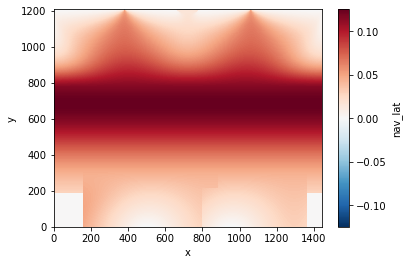

In [5]:
(ds_V.nav_lat - ds_T.nav_lat).plot()

In [23]:
RAD_EARTH = 6.387e6

tmp_dx = ((- ds_T['bounds_lon'].isel(nvertex=slice(0,4,3)).mean('nvertex') 
           + ds_T['bounds_lon'].isel(nvertex=slice(1,3)).mean('nvertex')) 
          * np.cos(ds_T['nav_lat'] * np.pi / 180.) * (2 * np.pi * RAD_EARTH / 360.))

tmp_dy = ((ds_T['bounds_lat'].isel(nvertex=slice(2,4)).mean('nvertex') 
           - ds_T['bounds_lat'].isel(nvertex=slice(0,2)).mean('nvertex')) 
          * (2 * np.pi * RAD_EARTH / 360.))

Text(0.5, 1.0, 'dy')

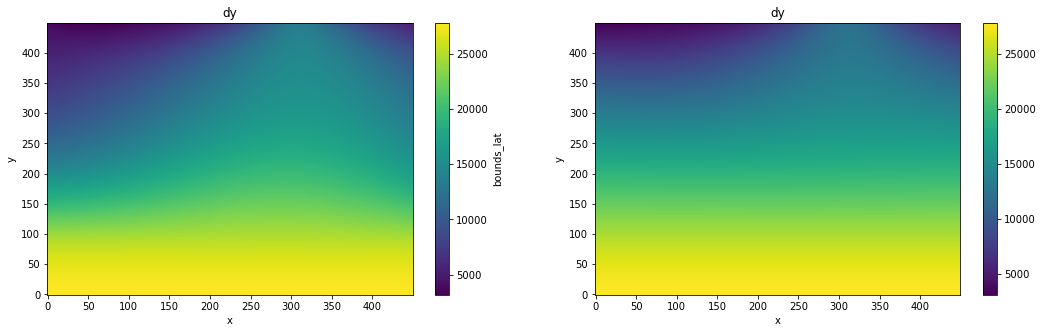

In [27]:
fig = plt.figure(figsize=[18,5])

plt.subplot(1,2,1)
tmp_dy.isel(x=slice(750,1200), y = slice(700, 1150)).plot()
plt.title('dy')

plt.subplot(1,2,2)
tmp_dx.isel(x=slice(750,1200), y = slice(700, 1150)).plot()
plt.title('dy')

In [11]:
print(ds_T['bounds_lon'].isel(y=700, x=700).values)
print(ds_T['bounds_lat'].isel(y=700, x=700).values)

[-112.375 -112.125 -112.125 -112.375]
[3.8720493 3.8720493 4.121441  4.121441 ]


In [55]:
ds_T['deptht_bounds'].diff('axis_nbounds')

<xarray.DataArray 'deptht_bounds' (deptht: 75, axis_nbounds: 1)>
array([[  1.0239066],
       [  1.0792834],
       [  1.1481192],
       [  1.2337434],
       [  1.3401852],
       [  1.4722052],
       [  1.6352429],
       [  1.8352118],
       [  2.0780945],
       [  2.369277 ],
       [  2.712654 ],
       [  3.1096478],
       [  3.5584164],
       [  4.0536633],
       [  4.5873146],
       [  5.150135 ],
       [  5.7339096],
       [  6.333458 ],
       [  6.948097 ],
       [  7.582039 ],
...
       [164.05664  ],
       [169.03613  ],
       [173.56226  ],
       [177.64746  ],
       [181.31226  ],
       [184.5813   ],
       [187.48242  ],
       [190.04639  ],
       [192.30273  ],
       [194.28223  ],
       [196.01294  ],
       [197.52246  ],
       [198.83594  ],
       [199.97656  ],
       [200.96533  ],
       [201.8208   ],
       [202.56104  ],
       [203.1997   ],
       [203.75098  ],
       [204.22852  ]], dtype=float32)
Coordinates:
  * deptht   (deptht) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
Dimensions without coordinates: axis_nbounds

In [63]:
# Create a new dataset 

RAD_EARTH = 6.387e6

ds_area = xr.Dataset()
ds_area['area_t'] = ds_T['area'] #.isel(x=slice(750,1200), y = slice(700, 1150))

ds_area['deptht'] = ds_T['deptht']
ds_area['dz_t'] = ds_T['deptht_bounds'].diff('axis_nbounds').mean('axis_nbounds')

ds_area['depthw'] = ds_W['depthw']
ds_area['dz_w'] = ds_W['depthw_bounds'].diff('axis_nbounds').mean('axis_nbounds')

# define coords and assign cell areas
ds_area['xu'] = xr.DataArray(ds_area.x.values + 0.5, dims=['xu'])
ds_area['yv'] = xr.DataArray(ds_area.y.values + 0.5, dims=['yv'])

ds_area = ds_area.drop(['xu', 'yv'])

ds_area['area_u'] = xr.DataArray(ds_U['area'].values, dims=['y','xu'])
ds_area['area_v'] = xr.DataArray(ds_V['area'].values, dims=['yv','x'])

# compute cell mean widths at t, u, v points
tmp_dx = ((- ds_T['bounds_lon'].isel(nvertex=slice(0,4,3)).mean('nvertex') 
           + ds_T['bounds_lon'].isel(nvertex=slice(1,3)).mean('nvertex')) 
          * np.cos(ds_T['nav_lat'] * np.pi / 180.) * (2 * np.pi * RAD_EARTH / 360.))

tmp_dy = ((ds_T['bounds_lat'].isel(nvertex=slice(2,4)).mean('nvertex') 
           - ds_T['bounds_lat'].isel(nvertex=slice(0,2)).mean('nvertex')) 
          * (2 * np.pi * RAD_EARTH / 360.))

ds_area['dx_t'] = xr.DataArray(tmp_dx.values, dims=['y','x'])
ds_area['dy_t'] = xr.DataArray(tmp_dy.values, dims=['y','x'])

tmp_dx = ((- ds_U['bounds_lon'].isel(nvertex=slice(0,4,3)).mean('nvertex') 
           + ds_U['bounds_lon'].isel(nvertex=slice(1,3)).mean('nvertex')) 
          * np.cos(ds_U['nav_lat'] * np.pi / 180.) * (2 * np.pi * RAD_EARTH / 360.))

tmp_dy = ((ds_U['bounds_lat'].isel(nvertex=slice(2,4)).mean('nvertex') 
           - ds_U['bounds_lat'].isel(nvertex=slice(0,2)).mean('nvertex')) 
          * (2 * np.pi * RAD_EARTH / 360.))

ds_area['dx_u'] = xr.DataArray(tmp_dx.values, dims=['y','xu'])
ds_area['dy_u'] = xr.DataArray(tmp_dy.values, dims=['y','xu'])

tmp_dx = ((- ds_V['bounds_lon'].isel(nvertex=slice(0,4,3)).mean('nvertex') 
           + ds_V['bounds_lon'].isel(nvertex=slice(1,3)).mean('nvertex')) 
          * np.cos(ds_V['nav_lat'] * np.pi / 180.) * (2 * np.pi * RAD_EARTH / 360.))

tmp_dy = ((ds_V['bounds_lat'].isel(nvertex=slice(2,4)).mean('nvertex') 
           - ds_V['bounds_lat'].isel(nvertex=slice(0,2)).mean('nvertex')) 
          * (2 * np.pi * RAD_EARTH / 360.))

ds_area['dx_v'] = xr.DataArray(tmp_dx.values, dims=['yv','x'])
ds_area['dy_v'] = xr.DataArray(tmp_dy.values, dims=['yv','x'])

# get lat-lon values
ds_area['nav_lat_u'] = xr.DataArray(ds_U['nav_lat'].values, dims=['y','xu'])
ds_area['nav_lat_v'] = xr.DataArray(ds_V['nav_lat'].values, dims=['yv','x'])

ds_area['nav_lon_u'] = xr.DataArray(ds_U['nav_lon'].values, dims=['y','xu'])
ds_area['nav_lon_v'] = xr.DataArray(ds_V['nav_lon'].values, dims=['yv','x'])

# coordinates for north atlantic only
ds_area = ds_area.isel(x=slice(750,1200), y = slice(700, 1150), xu=slice(750,1200), yv = slice(700, 1150))

#DX = xr.DataArray(dx,coords=[("yh",lat), ("xh",lon)])
#DY = xr.DataArray(dy,coords=[("yh",lat), ("xh",lon)])

In [64]:
ds_area

<xarray.Dataset>
Dimensions:    (y: 450, x: 450, deptht: 75, depthw: 75, xu: 450, yv: 450)
Coordinates:
    nav_lat    (y, x) float32 3.997 3.997 3.997 3.997 ... 73.44 73.34 73.24
    nav_lon    (y, x) float32 ...
  * deptht     (deptht) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * depthw     (depthw) float32 0.0 1.024 2.103 ... 5.393e+03 5.596e+03 5.8e+03
Dimensions without coordinates: y, x, xu, yv
Data variables: (12/15)
    area_t     (y, x) float32 ...
    dz_t       (deptht) float32 1.024 1.079 1.148 1.234 ... 203.2 203.8 204.2
    dz_w       (depthw) float32 1.0 1.05 1.112 1.189 ... 202.2 202.9 203.5 204.0
    area_u     (y, xu) float32 7.691e+08 7.691e+08 ... 1.652e+08 1.65e+08
    area_v     (yv, x) float32 7.688e+08 7.688e+08 ... 1.651e+08 1.649e+08
    dx_t       (y, x) float32 2.78e+04 2.78e+04 2.78e+04 ... 5.227e+03 5.201e+03
    ...         ...
    dx_v       (yv, x) float32 2.78e+04 2.78e+04 ... 5.182e+03 5.157e+03
    dy_v       (yv, x) float32 2.78e+04 2.78e+04 2.78e+04 ... 5.31e+03 5.278e+03
    nav_lat_u  (y, xu) float32 3.997 3.997 3.997 3.997 ... 73.39 73.29 73.18
    nav_lat_v  (yv, x) float32 4.121 4.121 4.121 4.121 ... 73.47 73.36 73.26
    nav_lon_u  (y, xu) float32 -99.62 -99.38 -99.12 -98.88 ... 51.16 51.33 51.49
    nav_lon_v  (yv, x) float32 -99.75 -99.5 -99.25 -99.0 ... 51.27 51.43 51.59

In [66]:
save_path="/home/users/hkhatri/DePreSys4_Data/Data_Consolidated/"

ds_area.to_netcdf(save_path + 'Ocean_Area_Updated.nc')